# Disease detection from Chest X-Ray

### Installing Libraries

In [42]:
# Data manipulation
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning utilities
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow and Keras for building CNN models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


### Load Dataset

In [2]:
data_directory= '/Users/bakeryehya/Desktop/DeepLearning Project/chest_xray'

In [ ]:
train_data_generation = ImageDataGenerator(
    rescale=1./255,               
    rotation_range=15,             
    width_shift_range=0.1,        
    height_shift_range=0.1,        
    shear_range=0.1,            
    zoom_range=0.1,                
    horizontal_flip=True           
)   

In [23]:
train_data_gen = train_data_generation.flow_from_directory(
    f"{data_directory}/train", 
    target_size=(150,150), 
    class_mode='binary', 
    batch_size=32
)   

Found 5216 images belonging to 2 classes.


In [24]:
test_data_gen = train_data_generation.flow_from_directory(
    f"{data_directory}/test",
    target_size=(150, 150),
    class_mode='binary',
    batch_size=32,
)

Found 624 images belonging to 2 classes.


# Validate the data

### This part displays a grid of 25 sample images from the training dataset along with their corresponding labels. It helps to quickly visualize the data and confirm that the images and labels are correctly paired

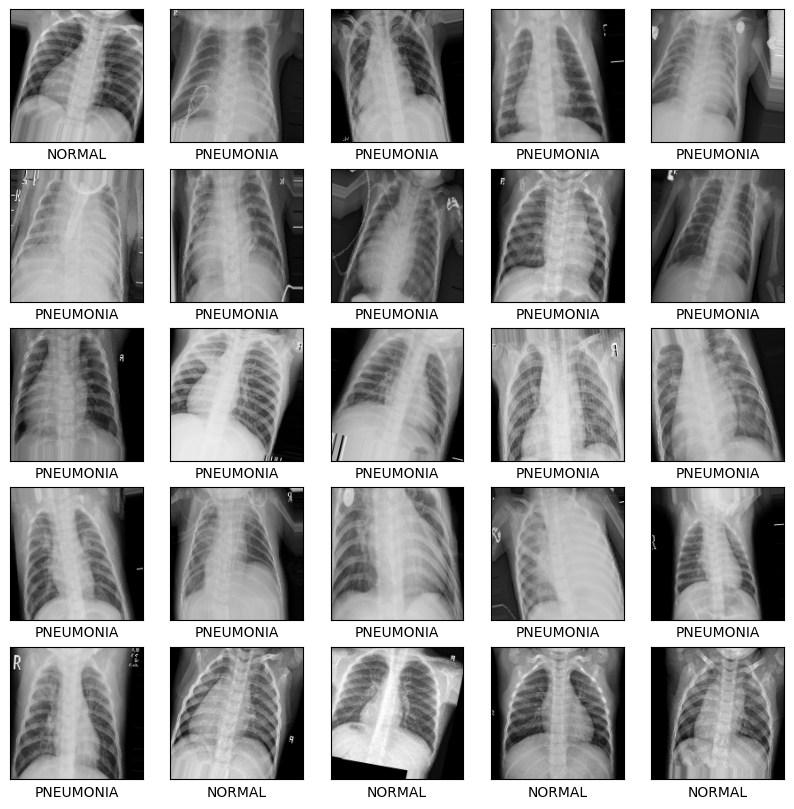

In [25]:
class_names = ['NORMAL', 'PNEUMONIA']

images, labels = next(train_data_gen)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    label = int(labels[i])
    plt.xlabel(class_names[label])
plt.show()

### This part counts and visualizes the number of images available for each class in the training set using a bar chart. It provides insight into the class distribution and helps identify any potential imbalance in the dataset.

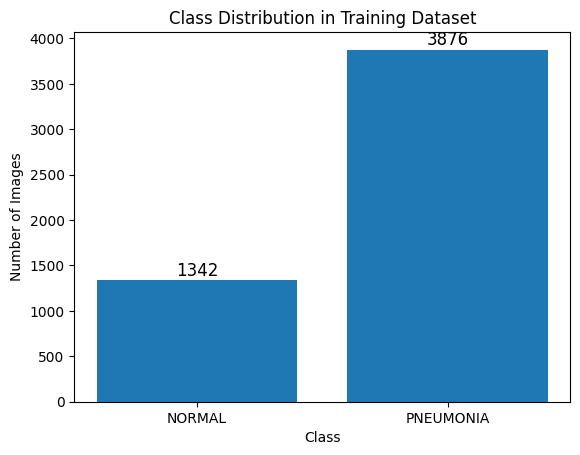

In [26]:
train_dir = '/Users/bakeryehya/Desktop/DeepLearning Project/chest_xray/chest_xray/train'
class_names = ['NORMAL', 'PNEUMONIA']
counts = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    count = len(os.listdir(class_path))
    counts.append(count)

bars = plt.bar(class_names, counts)
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, 
             str(height), ha='center', va='bottom', fontsize=12)

plt.show()


# Create the convolutional base
### This code defines the convolutional base of the model, which extracts important features from input images using convolutional and pooling layers. This base acts as the foundational part of the CNN before classification layers are added.

In [27]:
model = models.Sequential()

### This code builds a simple convolutional neural network (CNN) model with multiple convolution and max pooling layers. The model extracts hierarchical features from input images (150x150 RGB) by progressively learning spatial patterns through convolutional filters and reducing spatial dimensions via pooling.


In [ ]:
model = models.Sequential()

# First convolutional layer with 32 filters, 3x3 kernel, ReLU activation; expects input images of size 150x150 with 3 color channels
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))  # Downsamples feature maps by a factor of 2

# Second convolutional layer with 64 filters and ReLU activation
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))  # Further downsampling

# Third convolutional layer with 64 filters and ReLU activation
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))  # Further downsampling

# Fourth convolutional layer with 64 filters and ReLU activation
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))  # Final downsampling


In [55]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

### This code adds the classifier part of the CNN by flattening the 2D feature maps into a 1D vector, then passing it through a fully connected dense layer with ReLU activation. A dropout layer is included to reduce overfitting by randomly disabling neurons during training, followed by the output layer with 2 units (typically for classification into 2 classes).

In [59]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2))


In [60]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 884,834 (3.38 MB)

 Trainable params: 295,500 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 589,334 (2.25 MB)

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_data_gen,
    validation_data=test_data_gen,
    epochs=10,
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 241ms/step - accuracy: 0.6632 - loss: 1.1628 - val_accuracy: 0.6571 - val_loss: 0.7328
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 247ms/step - accuracy: 0.8322 - loss: 0.2975 - val_accuracy: 0.7516 - val_loss: 0.7821
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 257ms/step - accuracy: 0.8865 - loss: 0.2748 - val_accuracy: 0.8093 - val_loss: 0.5070
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 283ms/step - accuracy: 0.9264 - loss: 0.2169 - val_accuracy: 0.7821 - val_loss: 0.6699
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 430ms/step - accuracy: 0.9326 - loss: 0.1909 - val_accuracy: 0.8429 - val_loss: 0.5454
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 440ms/step - accuracy: 0.9351 - loss: 0.1874 - val_accuracy: 0.8622 - val_loss: 0.4402
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 398ms/step - accuracy: 0.9281 - loss: 0.1928 - val_accuracy: 0.7692 - val_loss: 0.6147
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 410ms/step - accuracy: 0.9384 - loss: 0

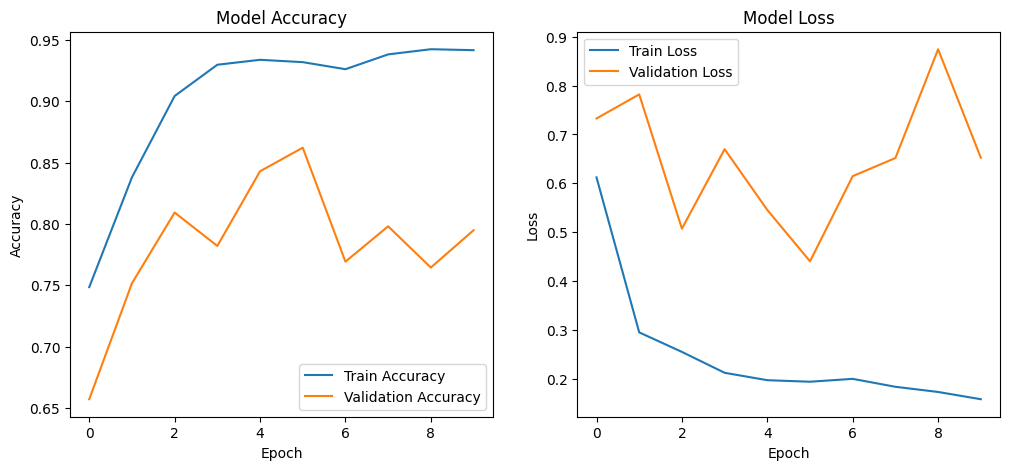

In [64]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

##### The left graph shows the training and validation accuracy over epochs, illustrating how well the model learns to classify the data, while the right graph displays the training and validation loss, indicating how the error decreases during training and helping to identify potential overfitting.

In [65]:
from tensorflow.keras.applications import MobileNetV2

# Load the pretrained MobileNetV2 model without the top classification layers
base_model = MobileNetV2(input_shape=(150, 150, 3),
                         include_top=False,  # remove MobileNet's default classifier
                         weights='imagenet')

base_model.trainable = False  # Freeze the base model initially

# Build your new model on top of MobileNetV2 base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce feature maps to a vector
    layers.Dropout(0.5),              # Regularization
    layers.Dense(2)                   # Output layer for 2 classes (logits) 
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_data_gen,
    validation_data=test_data_gen,
    epochs=10,
)

/var/folders/cy/t09s5_qx2_q_hwxrg8vh5xgr0000gp/T/ipykernel_16536/1448175336.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150, 150, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 15s 2us/step
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 229ms/step - accuracy: 0.7858 - loss: 0.5657 - val_accuracy: 0.7949 - val_loss: 0.4900
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 221ms/step - accuracy: 0.8896 - loss: 0.2555 - val_accuracy: 0.7660 - val_loss: 0.6369
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 230ms/step - accuracy: 0.9082 - loss: 0.2180 - val_accuracy: 0.7981 - val_loss: 0.5072
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 304ms/step - accuracy: 0.9189 - loss: 0.1994 - val_accuracy: 0.8221 - val_loss: 0.4382
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 465ms/step - accuracy: 0.9125 - loss: 0.2034 - val_accuracy: 0.8157 - val_loss: 0.5107
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 397ms/step - accuracy: 0.9296 - loss: 0.1867 - val_accuracy: 0.8269 - val_loss: 0.4474
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 379ms/step - accuracy: 0.9276 - loss: 0.1808 - val_accuracy: 0.7644 - val_loss: 0.7067
Epoch 8/10
163/163 ━━━━━━━━━━━━━━

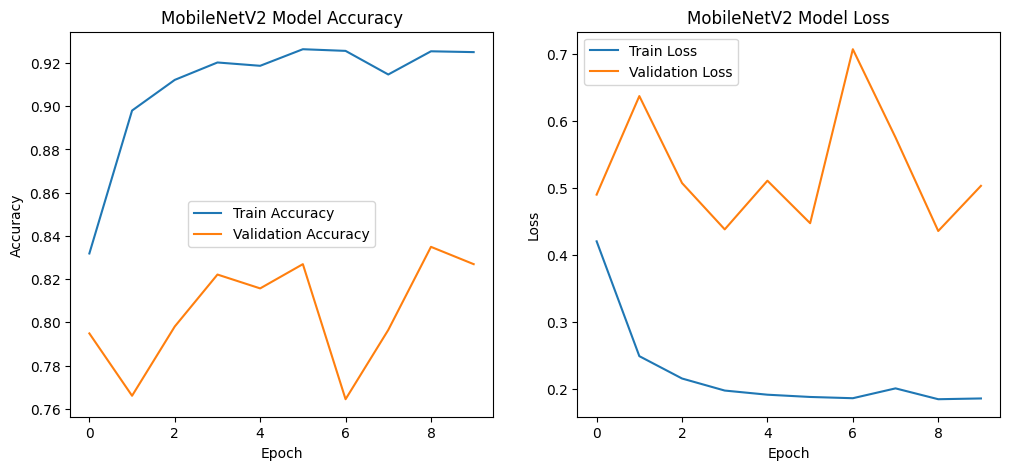

In [66]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Model Comparison Summary:

### We trained two models on the chest X-ray dataset: a custom CNN and a MobileNetV2 transfer learning model. The MobileNetV2 model showed faster convergence with higher initial training accuracy and competitive validation accuracy throughout training. Both models achieved similar peak validation accuracies (~82-86%), but exhibited some overfitting in later epochs as validation accuracy fluctuated and validation loss increased slightly. Overall, transfer learning with MobileNetV2 offers strong performance and stability, making it a promising approach for this classification task. Further improvements can be made using fine-tuning and regularization techniques

# Evaluation


In [70]:
# Get all validation data and labels
test_data_gen.reset()  # Reset generator before prediction
pred_probs = model.predict(test_data_gen, verbose=1)

# For SparseCategoricalCrossentropy with logits=True, apply softmax if needed:
# If from_logits=True, you need to apply softmax to get probabilities
# If from_logits=False, pred_probs are probabilities already

# If logits (from_logits=True):
pred_probs = tf.nn.softmax(pred_probs).numpy()

# Get predicted class indices
y_pred = np.argmax(pred_probs, axis=1)

# Get true labels
y_true = test_data_gen.classes


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step


# Accuracy, Precision, Recall, F1-score

### These metrics provide a comprehensive evaluation of the model’s classification performance. Accuracy shows overall correctness, while precision and recall measure the model’s ability to correctly identify positive cases and avoid false alarms. The F1-score balances precision and recall, offering a single metric for performance on imbalanced data.

In [71]:
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

      NORMAL       0.38      0.20      0.26       234
   PNEUMONIA       0.63      0.81      0.70       390

    accuracy                           0.58       624
   macro avg       0.50      0.50      0.48       624
weighted avg       0.54      0.58      0.54       624



# Confusion Matrix
### The confusion matrix visualizes the model’s predictions compared to the true labels, showing how many samples were correctly classified and where misclassifications occur. This helps identify specific classes the model struggles with.

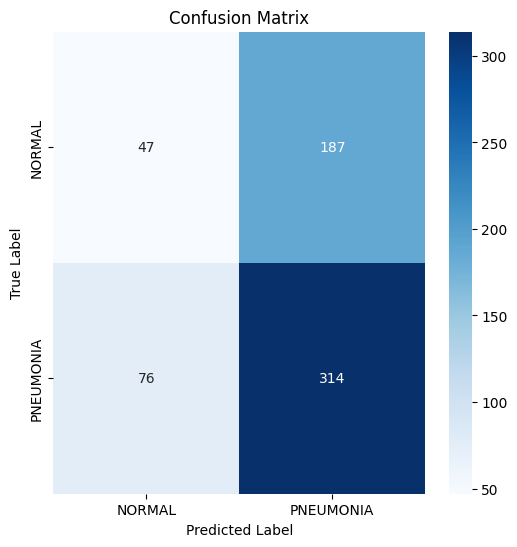

In [72]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Training vs Validation Performance (Loss & Accuracy Curves)
### The plots of training and validation accuracy and loss over epochs help diagnose model behavior during training. Ideally, both curves improve and converge; divergence or validation metric deterioration may indicate overfitting or underfitting.

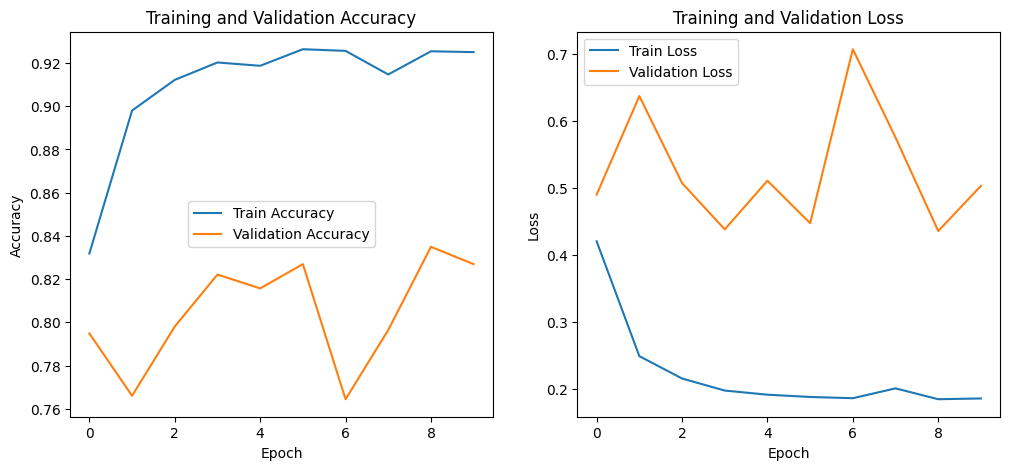

In [73]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Final Summary
### In this project, we developed a convolutional neural network (CNN) from scratch and applied transfer learning using MobileNetV2 to classify chest X-ray images as Normal or Pneumonia. Both approaches achieved strong performance, with transfer learning generally providing more stable and higher validation accuracy. Evaluation metrics including accuracy, precision, recall, and F1-score, along with the confusion matrix, confirmed the models’ effectiveness. Training and validation curves highlighted some signs of overfitting, suggesting that further tuning and regularization could enhance generalization. Overall, transfer learning is a powerful strategy for medical image classification tasks when labeled data is limited.

